In [1]:
%cd ..

f:\DS Lab\OT\KPG_GWB


C:\Users\ngtdu\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import os
import ot

from sklearn.cluster import KMeans
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from optimal_transport.models import KeypointGW, GW_Barycenter, GW, KPG_RL_GW
from sklearn import manifold
from ot.gromov import _gw, gromov_barycenters

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import ot.plot
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
c:\Users\ngtdu\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:
def get_data(num=20):
    np.random.seed(3)
    source = []
    target = []
    centers = [np.array([[-1,-1]]),np.array([[-3,2]]),np.array([[-2,3]]),
               np.array([[0,1]]),np.array([[-0.5,0.5]]),np.array([[-1,2]])]
    for i in range(3):
        source.append(np.random.multivariate_normal(np.array([0,0]),cov=0.05*np.array([[1,0],[0,1]]),size=num)+centers[i])
        target.append(
            np.random.multivariate_normal(np.array([0, 0]), cov=0.05 * np.array([[1, 0], [0, 1]]), size=num) + centers[
                i+3])
    return source,target

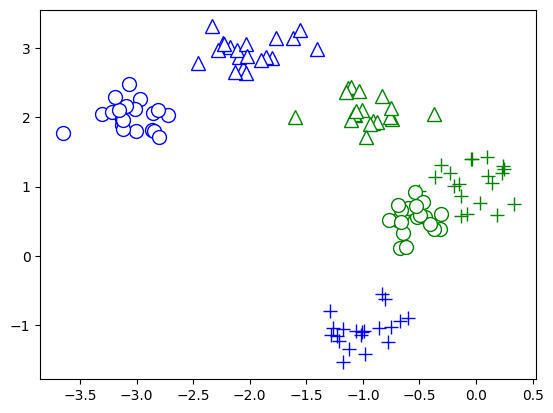

In [4]:
num = 20
source_,target_ = get_data(num)
s = ["+","o","^"]
# plot data
for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")

In [5]:
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensioned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=3)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos

Matching accuracy:100.0%


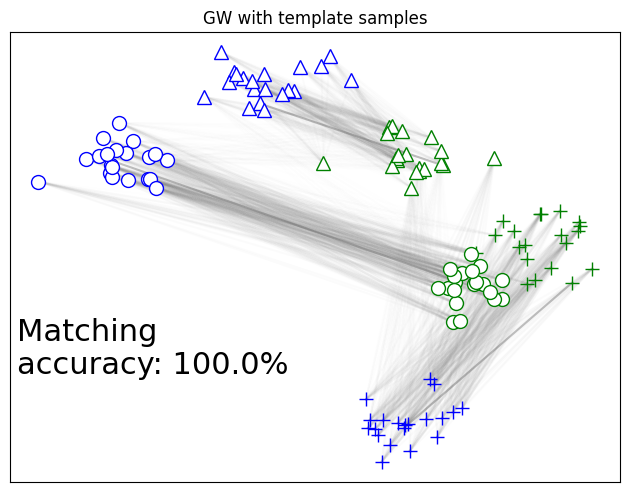

In [6]:
labels = [0]*num + [1]*num + [2]*num
labels = np.array(labels)
source = np.vstack(source_)
target = np.vstack(target_)

plt.xticks([])
plt.yticks([])
plt.tight_layout()

p = np.ones(len(source))/len(source)
q = np.ones(len(target))/len(target)
weights = [p, q]

I = [3, num+6, 2*num+1]
J = [8, num+13, 2*num+3]
K = list(zip(I, J))

model = KeypointGW(p=None, loss_fun='square_loss', num_free_barycenters=3, n_clusters=3, tol = 1e-5, max_iters=1000)

result = model.fit(source, labels, target, p, q, K)
C = result.Cz_
# M = smacof_mds(C, 2)
Px = result.Pa_
Py = result.Pb_
P = Px.dot(Py)
L = result.L

ot.plot.plot2D_samples_mat(source, target, P, c="grey", alpha=0.5)

for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")
    

if not os.path.exists("figure"):
    os.makedirs("figure")
pl.title('GW with template samples')

pred = np.argmax(P,axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
print("Matching accuracy:{:.1f}%".format(acc*100))

plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100),fontsize=22)
plt.savefig("figure/KP_GWB.pdf")
plt.show()


Matching accuracy:6.7%


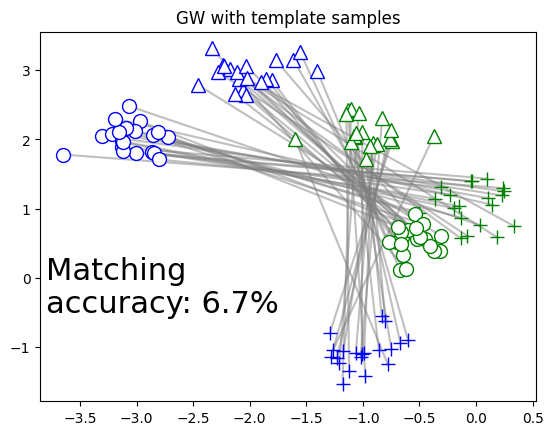

In [9]:
model = GW(loss_fun='square_loss', max_iters=2000)

result = model.fit(source, labels, target, p, q, K)
P = result.P_

ot.plot.plot2D_samples_mat(source, target, P, c="grey", alpha=0.5)

for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")

if not os.path.exists("figure"):
    os.makedirs("figure")
pl.title('GW with template samples')

pred = np.argmax(P,axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
print("Matching accuracy:{:.1f}%".format(acc*100))

plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100),fontsize=22)
plt.savefig("figure/GW.pdf")
plt.show()



[[ 0.05459701 -0.07511164]
 [ 0.08604395 -0.16991459]
 [-0.24123547  0.32543854]
 [-0.18140267  0.24392753]
 [ 0.12237396 -0.10871545]
 [ 0.15962322 -0.2156244 ]]
Matching accuracy:16.7%


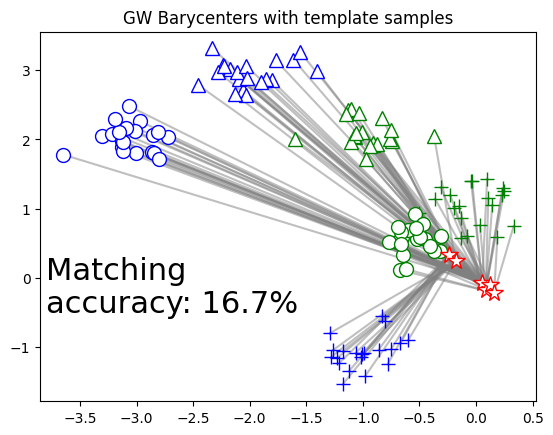

In [11]:
model = GW_Barycenter(N=6, loss_fun='square_loss', max_iters=10000, log=True)

result = model.fit(source, labels, target, p, q, K)
C = result.T[1]
M = smacof_mds(C, 2)
print(M)
Ps = result.T[0]
Px = Ps[0].T
Py = Ps[1]
P = Px.dot(Py)


ot.plot.plot2D_samples_mat(source, M, Px, c="grey", alpha=0.5)
ot.plot.plot2D_samples_mat(M, target, Py, c="grey", alpha=0.5)

for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")
# plot anchors
t = 3
for i in range(len(M)):
        plt.plot(np.vstack(M)[i][0], np.vstack(M)[i][1],'r*', markersize=10+t, markerfacecolor="white")

if not os.path.exists("figure"):
    os.makedirs("figure")
pl.title('GW Barycenters with template samples')

pred = np.argmax(P,axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
print("Matching accuracy:{:.1f}%".format(acc*100))

plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100),fontsize=22)
plt.savefig("figure/GW_Barycenter.pdf")
plt.show()



Matching accuracy:90.0%


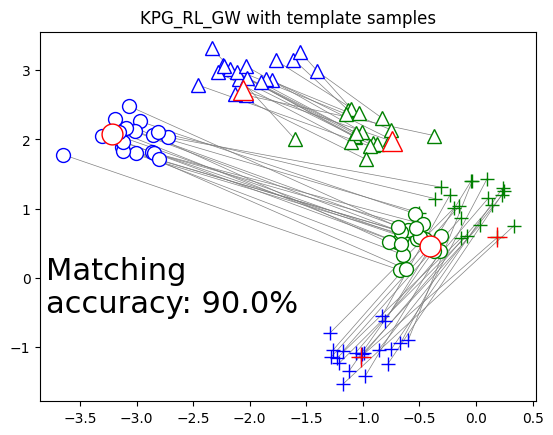

In [12]:
model = KPG_RL_GW()

result = model.fit(source, labels, target, p, q, K)
P = result.P_

# ot.plot.plot2D_samples_mat(source, target, P, c="grey", alpha=0.5)
source_transport = P@target/p.reshape((-1,1))
for i in range(len(source)):
    plt.plot([source[i][0],source_transport[i][0]],[source[i][1],source_transport[i][1]],
             '-',color="grey",linewidth=0.5)

for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")
    
t = 5
for i in range(len(I)):
    plt.plot(source[I[i]][0],source[I[i]][1],'r{}'.format(s[i]), markersize=10 + t, markerfacecolor="white")
    plt.plot(source_transport[I[i]][0], source_transport[I[i]][1], 'r{}'.format(s[i]), markersize=10 + t, markerfacecolor="white")

if not os.path.exists("figure"):
    os.makedirs("figure")
pl.title('KPG_RL_GW with template samples')

pred = np.argmax(P,axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
print("Matching accuracy:{:.1f}%".format(acc*100))

plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100),fontsize=22)
plt.savefig("figure/KPG_RL_GW.pdf")
plt.show()